# SP500 Model

### Version 1.0

---

In [1]:
# needed to import parent folders
import sys
sys.path.append("../")

In [2]:
import torch
import numpy as np
try:
    import _pickle as pickle
except:
    import pickle
from collections import OrderedDict

In [3]:
from neuralnet import NeuralNetwork
from tools.data_handler import DataHandler

In [4]:
with open('stats/training_stats.p', 'rb') as stats_file:
    statistics = pickle.load(stats_file)
    
data_handler = DataHandler()
data_handler.initialize('../tools/serialized_tool_objects/datahandler.p')
    
class SP500Predictor:
    
    def __init__(self):
        self.models = {}

    
    def activate(self, model_dir='models'):
        for symbol in statistics.keys():
            model = NeuralNetwork(15) # if features get added, this needs to change
            try:
                model.initialize('{}/{}_regressor.pth'.format(model_dir, symbol))
                self.models[symbol] = model
            except:
                continue
    
    
    def predict(self, *symbols, timerange='D'):
        predictions = OrderedDict()
        for symbol in symbols:
            if statistics[symbol]['near_real_price'] == 'X':
                try:
                    x = self.get_todays_values(symbol)
                    pred = self.models[symbol].predict([x])
                    predictions[symbol] = pred
                except:
                    continue
            else:
                predictions[symbol] = None # model is not "sure" enough
        return predictions
        #note: timeranges will be implemented next
        
    
    def predict_history(self, *symbols):
        predictions = OrderedDict()
        for symbol in symbols:
            if statistics[symbol]['near_real_price'] == 'X':
                preds = []
                X, _ = data_handler.load_from_npz(symbol)
                for x in X:
                    pred = self.models[symbol].predict([x])
                    preds.append(pred)
                predictions[symbol] = preds
            else:
                predictions[symbol] = None # model is not "sure" enough           
        return predictions
                
        
    def get_todays_values(self, symbol):
        # needs to be changed sometime in the future into an optimized solution!
        x, _ = data_handler.load_from_npz(symbol)
        return x[-1]

In [5]:
sp500_predictor = SP500Predictor()
sp500_predictor.activate()

In [6]:
sp500_predictor.predict('AAPL', 'GOOG', 'AMZN', 'A', 'AAL', 'FE')

OrderedDict([('AAPL', 155.0103759765625),
             ('GOOG', 1011.1766357421875),
             ('AMZN', 1501.06396484375),
             ('A', 68.15348052978516),
             ('AAL', None),
             ('FE', 33.489383697509766)])

---

### Analytics

In [7]:
import matplotlib.pyplot as plt
import datetime as dt

In [8]:
inputs = ['GOOG', 'AMZN', 'FE']

sp500_predictor.predict(*inputs)

OrderedDict([('GOOG', 1011.1766357421875),
             ('AMZN', 1501.06396484375),
             ('FE', 33.489383697509766)])

In [9]:
def validate_predictions(symbol):
    df = data_handler.load_from_db(symbol)
    df['Date'] = df['Day'].apply(lambda x: str(x)) \
         + "-" + df['Month'].apply(lambda x: str(x)) \
         + "-" + df['Year'].apply(lambda x: str(x))
    dates = [dt.datetime.strptime(day,'%d-%m-%Y').date() for day in df['Date']]
    true_history = df['Adj._Close_next'].values
    predicted_history = sp500_predictor.predict_history(symbol)
    predicted_history = np.array([value for key, value in predicted_history.items()]).flatten()
    return dates, true_history, predicted_history

def plot_validation(symbol):
    x, y_true, y_pred = validate_predictions(symbol)
    plt.figure(figsize=(12,12))
    plt.plot(x, y_true, label='Reality')
    plt.plot(x, y_pred, label='Prediction')
    plt.legend()
    plt.ylabel('Adjusted Price in USD')
    plt.xlabel('Date')
    plt.title('Chart for {}'.format(symbol))
    plt.show()

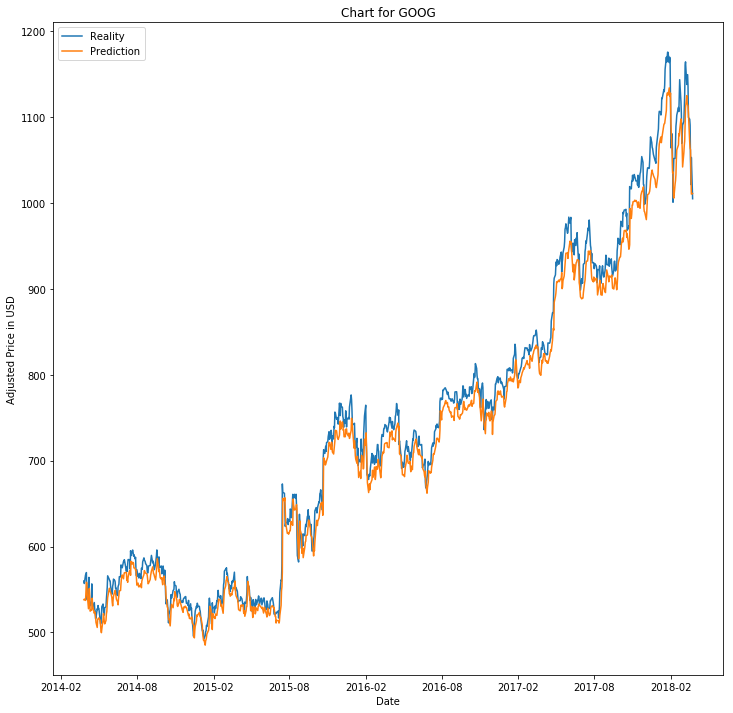

In [10]:
plot_validation('GOOG');